### Gathering Initial Info: Training Set

This notebook contains just the preliminary analysis of the training set. 

* training_set_metadata: Information about objects in the that doesn't change over time, like the coordinates of the object.

* training_set: Time series of observations of the objects. Maps to the metadata via object_id.

In [1]:
import os, gc, itertools
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.manifold import TSNE

from astropy.coordinates import SkyCoord
from astropy import units as u

In [2]:
gc.collect()
#read csv
training = pd.read_csv('../Train-Data/training_set.csv')

meta_training = pd.read_csv('../Train-Data/training_set_metadata.csv')

print ('check shapes: ', training.shape, meta_training.shape)
print ('\n')
print (training.head(5))

meta_training.head(5)

check shapes:  (1421705, 6) (7848, 12)


   object_id         mjd  passband        flux   flux_err  detected
0        615  59750.4229         2 -544.810303   3.622952         1
1        615  59750.4306         1 -816.434326   5.553370         1
2        615  59750.4383         3 -471.385529   3.801213         1
3        615  59750.4450         4 -388.984985  11.395031         1
4        615  59752.4070         2 -681.858887   4.041204         1


,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


#### Select Via Detected Flag
`detected`:  If 1, the object's brightness is significantly different at the 3-sigma level relative to the reference template. Only objects with at least 2 detections are included in the dataset. Boolean

In [3]:
### how many with detected boolean flags
training_detected = training.loc[training['detected']==1]
print ('how many with detected boolean flags: ', training_detected.shape)
# if we selected based on detected: percentage of data loss: 
print ('if we select based on detected: percentage of data loss: ', 
       (1-(training_detected.shape[0]/training.shape[0])))
### so we proceed to go with both detected and not detected


how many with detected boolean flags:  (236880, 6)
if we select based on detected: percentage of data loss:  0.8333831561399868


### Spectroscopic and Photometric Redshift

The given redshift for objects in our own galaxy is given
as zero. So let's see the source distribution-- 

   object_id          ra       decl       gal_l      gal_b  ddf  \
0        615  349.046051 -61.943836  320.796530 -51.753706    1   
1        713   53.085938 -27.784405  223.525509 -54.460748    1   
2        730   33.574219  -6.579593  170.455585 -61.548219    1   

   hostgal_specz  hostgal_photoz  hostgal_photoz_err  distmod  mwebv  target  \
0         0.0000          0.0000              0.0000      NaN  0.017      92   
1         1.8181          1.6267              0.2552  45.4063  0.007      88   
2         0.2320          0.2262              0.0157  40.2561  0.021      42   

   exgal  
0  False  
1   True  
2   True  
----------------------------------------------


Text(0.5, 1.0, 'Source Counts: Galactic & Extragalactic')

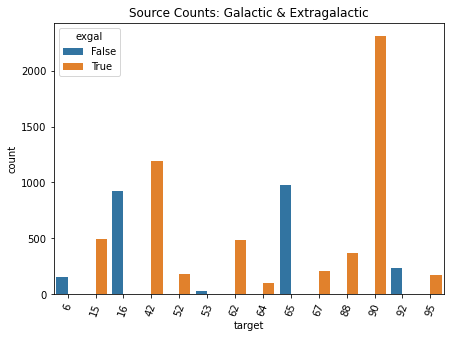

In [12]:
meta_training['exgal'] = np.where(meta_training['hostgal_specz']>0, True, False)
print (meta_training.head(3)) 
print ('----------------------------------------------')
## check the source category distribution gal and extragal
fig = plt.figure(figsize=(7, 5))
count_exgal_plt = sns.countplot(data=meta_training, x='target', hue='exgal', )
count_exgal_plt.set_xticklabels(count_exgal_plt.get_xticklabels(), rotation=70)
count_exgal_plt.set_title('Source Counts: Galactic & Extragalactic')

### Source Distribution on the Sky

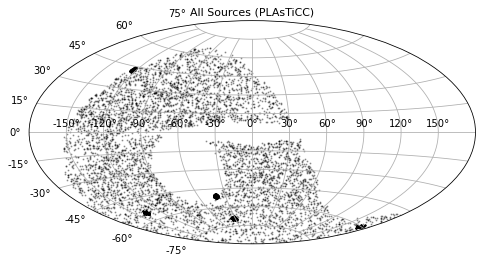

In [13]:
### plot the skymap of the sources 
all_gal_l = meta_training['gal_l'].to_numpy()
all_gal_b = meta_training['gal_b'].to_numpy()

gal_all = SkyCoord(all_gal_l[:], all_gal_b[:], frame='galactic', unit=u.deg)

fig = plt.figure(figsize=(8, 5))
plt.subplot(111, projection='aitoff')
plt.grid(True)
plt.scatter(gal_all.l.wrap_at('180d').radian, gal_all.b.radian, color='black', alpha=0.3, s=1)
plt.title('All Sources (PLAsTiCC)', fontsize=11)
plt.show()

### Spectroscopic & Photometric Redshift (Ex-Gal & Gal Sources)

check shapes : gal, ex-gal:  (2325, 13) (5523, 13)
----------------------------------------
for ExtraGalactic Sources
----------------------------------------


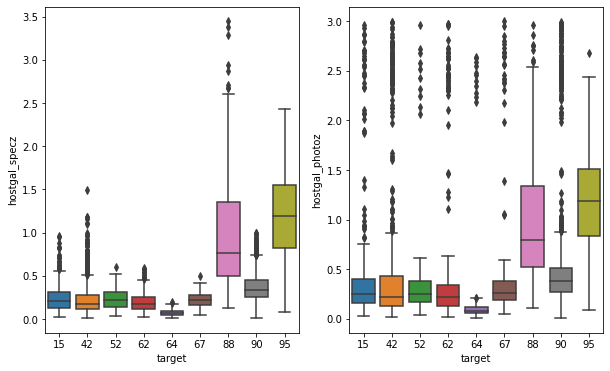

In [15]:
## seperate galactic and extragalactic sources: 
meta_training_exgalactic = meta_training.loc[meta_training['hostgal_specz']>0.0]
meta_training_galactic = meta_training.loc[meta_training['hostgal_specz']==0.0]
print ('check shapes : gal, ex-gal: ', meta_training_galactic.shape, meta_training_exgalactic.shape)

print ('----------------------------------------')

print ('for ExtraGalactic Sources')

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
sns.boxplot(data=meta_training_exgalactic, y='hostgal_specz', x='target', ax=axes[0])
sns.boxplot(data=meta_training_exgalactic, y='hostgal_photoz', x='target', ax=axes[1])

print ('----------------------------------------')


### Frequency of Observation at Different Passbands (u, g, r, i, z, y)



   object_id         mjd  passband        flux   flux_err  detected passband_n
0        615  59750.4229         2 -544.810303   3.622952         1          r
1        615  59750.4306         1 -816.434326   5.553370         1          g
2        615  59750.4383         3 -471.385529   3.801213         1          i
3        615  59750.4450         4 -388.984985  11.395031         1          z
4        615  59752.4070         2 -681.858887   4.041204         1          r


-------------------------------


<AxesSubplot:xlabel='passband_n', ylabel='count'>

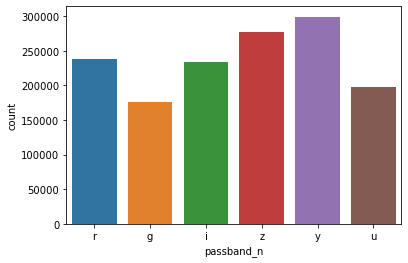

In [16]:
my_map = {0:'u', 1:'g', 2:'r', 3:'i', 4:'z', 5:'y'}
training['passband_n'] = training['passband'].map(my_map)

print (training.head(5))

print ('\n')

print ('-------------------------------')

sns.countplot(x=training['passband_n'])# u, g, r, i, z, y